# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
# load packages
import math
import numpy as np
import pandas as pd
import sklearn as skit
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from sklearn.preprocessing import StandardScaler
import datetime
from datetime import date

# bez násl. řádku někdy nefunguje vykreslování grafů v Jupyter noteboocích
%matplotlib inline 
matplotlib.style.use('ggplot')

# for debug
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
df = pd.read_csv("eshop.csv")

In [3]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


# Řešení

## RFM

In [4]:
now = datetime.datetime.strptime('2015/12/19', "%Y/%m/%d") # fake today date

# RFM
dfx = df.groupby('Customer ID').agg(
    LastRecord = ('Date', 'max'), # nejpozdější datum nákupu
    Frequency = ('Subtotal', 'count'), # spočítat kolik je záznamů
    Monetary = ('Subtotal', 'sum'), # spočítat celkem utracené peníze
)

# Z LastRecord získáme Recency vůči fake now:
dfx['Recency'] = pd.to_datetime(dfx['LastRecord']).apply(lambda x: (now - x).days)
dfx = dfx.drop(['LastRecord'], axis=1)

# Přehled dat
display(dfx.describe())
display(dfx.head(15))

,Frequency,Monetary,Recency
count,12829.000000,12829.000000,12829.000000
mean,1.746668,155.806657,1165.041936
std,2.010044,407.744435,720.635497
min,1.000000,1.180000,0.000000
25%,1.000000,32.040000,537.000000
50%,1.000000,64.810000,1149.000000
75%,2.000000,143.510000,1727.000000
max,45.000000,21392.380000,3103.000000


,Frequency,Monetary,Recency
Customer ID,,,
7,3,15.54,1011
9,1,13.20,3050
30,1,36.20,3025
34,1,86.00,3103
38,1,38.40,3097
41,1,18.50,2432
47,1,53.50,3092
48,1,39.30,3069
53,1,9.10,1517


## Shlukování

### Optimální hodnota k

Podle 4. cvičení určíme optimální k.

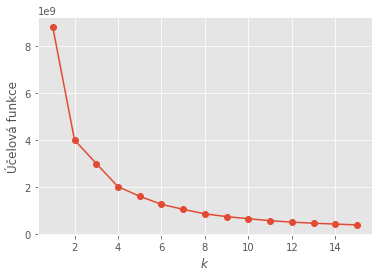

In [50]:
def find_optimal_k(data, pocet = 15):
    x = np.zeros(pocet)
    y = np.zeros(pocet)
    for i in range(0, pocet):
        kmeans = KMeans(n_clusters = i + 1, random_state = 666)
        kmeans.fit(data)
        y[i] = kmeans.inertia_
        x[i] = i + 1
        
    plt.xlabel('$k$')
    plt.ylabel('Účelová funkce')
    plt.plot(x, y, 'o-')
    plt.show()
    
find_optimal_k(dfx)

Z grafu jde vidět, že první zlom nastává již v `x = 2`. Tuto hodnotu bych vůči datům hodnotil jako příliš nízkou - rozdělí zákazníky jen na dvě poloviny. Máme 3 příznaky RFM, což znamená, že můžeme mít až 8 rozdělení s kombinacemi min/max. Z grafu jde vidět, že další zlom přichází v `x = 4`, což se zná jako hodnota, kterou prozkoumáme a případně prozkoumáme i hodnotu `x = 8`.

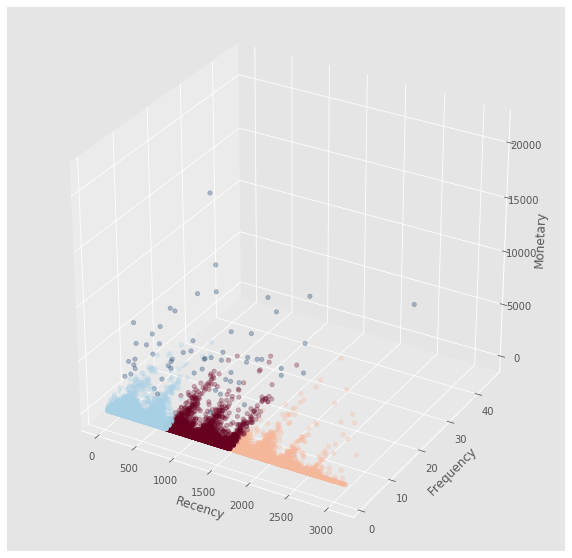

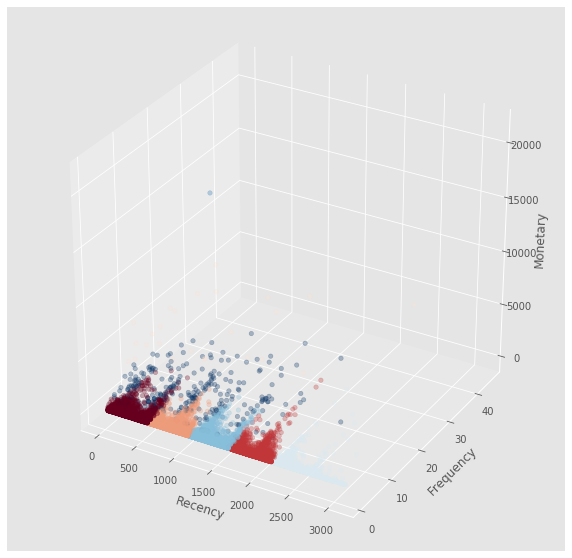

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=666, tol=0.0001, verbose=0)

In [51]:
def kmeans_for_k(data, k = 4):
    kmeans = KMeans(n_clusters = k, random_state = 666)
    kmeans.fit(data)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(data.Recency, data.Frequency, data.Monetary, c=kmeans.labels_, cmap='RdBu', alpha = 0.3)
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    plt.show()
    
    return kmeans
    
kmeans_for_k(dfx, 4)
kmeans_for_k(dfx, 8)

Pro `x = 4` i `x = 8` se nám data rozdělují ne úplně vhodně podle parametru Recency. Zkusíme tedy přeškálovat data standartním škálováním.

### Škálování dat

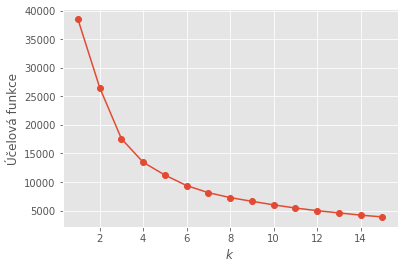

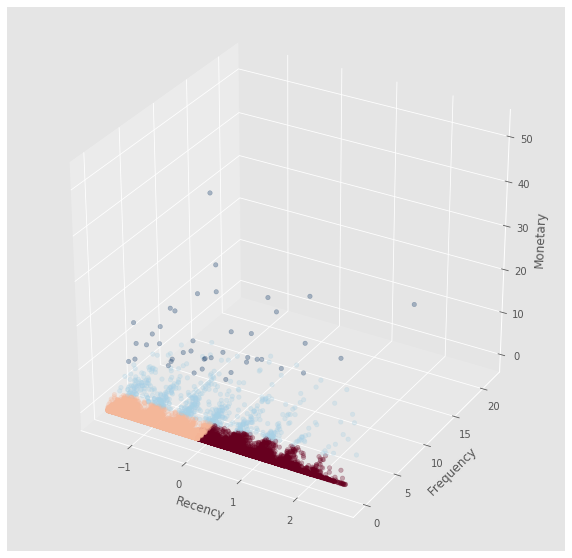

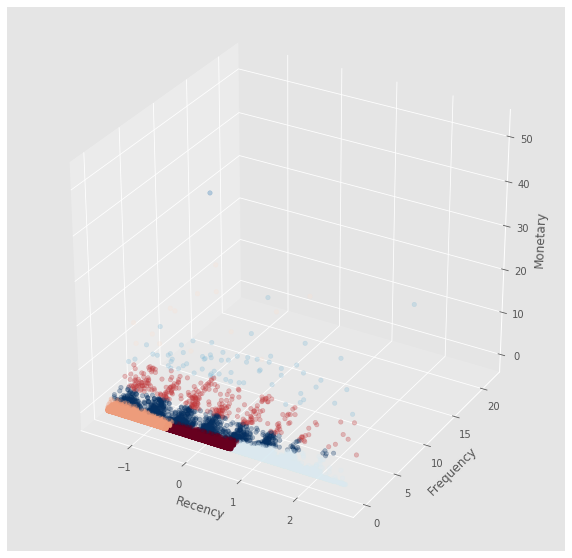

In [52]:
def scale_data(data):
    ss = StandardScaler()
    datax = ss.fit_transform(data)
    datax = pd.DataFrame(datax, index=data.index, columns=data.columns)
    return datax

dfy = scale_data(dfx)
find_optimal_k(dfy)
kmeans_for_k(dfy, 4)
kmeansx = kmeans_for_k(dfy, 8)

Přeškálovaná data vypadají lépe rozdělena, budeme tedy používat dále to.

### Zobrazení jednotlivých clusterů

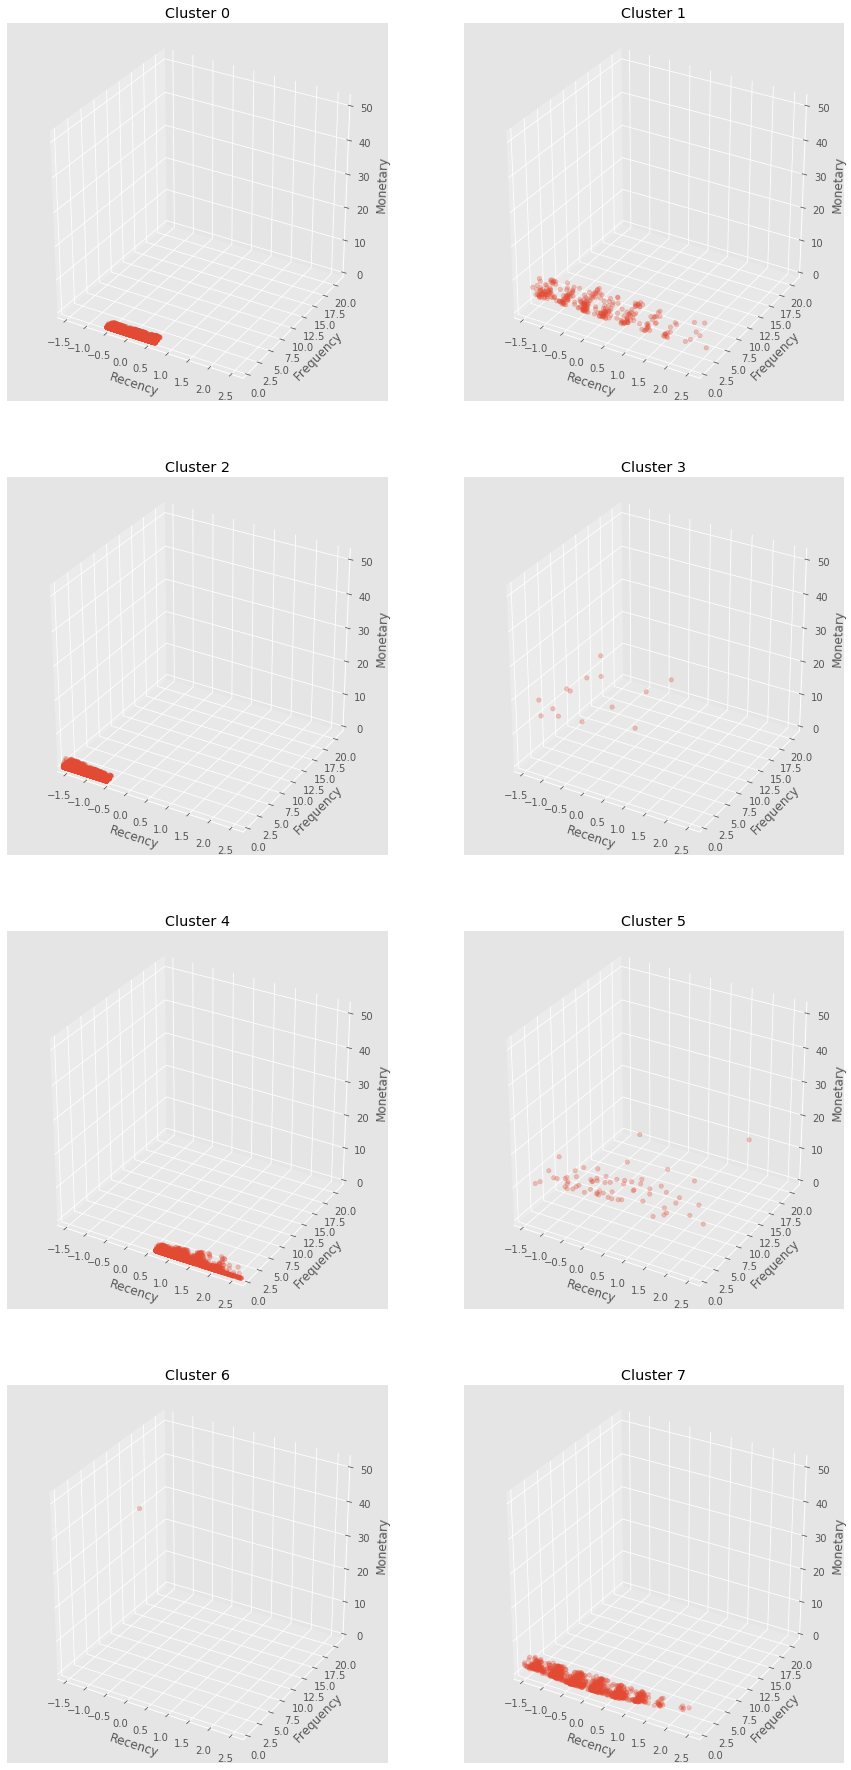

In [80]:
dfy["cluster"] = kmeansx.labels_
#display(dfy['cluster'])

recencyMin = dfy.Recency.min()
recencyMax = dfy.Recency.max()
frequencyMin =  dfy.Frequency.min()
frequencyMax =  dfy.Frequency.max()
monetaryMin =  dfy.Monetary.min()
monetaryMax =  dfy.Monetary.max()

fig = plt.figure(figsize=(15, kmeansx.n_clusters * 4))

for i in range(0, kmeansx.n_clusters):
    data = dfy[dfy['cluster'] == i]
    ax = fig.add_subplot(4, 2, i+1, projection='3d')
    ax.set(xlim=(recencyMin, recencyMax), ylim=(frequencyMin, frequencyMax), zlim=(monetaryMin, monetaryMax))
    ax.scatter3D(data.Recency, data.Frequency, data.Monetary, cmap='RdBu', alpha = 0.3)
    ax.title.set_text(f'Cluster {str(i)}')
    #ax.view_init(0, 0)
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')

### Superstar

"superstar" == zákazníci (vysoká monetary, vysoká frequency a nízká recency)

Po prozkoumání (včetně natáčení pomocí `ax.view_init(0, a)`) grafů vybereme jako vhodné kandidáty na superstar clustery 1, 3, 5 a 6. Cluster 6 obsahuje pouze 1 údaj, proto jej však kvůli nevypovídající hodnotě nemůžeme použít. Po bližším zkoumání dat nejvíce superstar odpovídá cluster 3.

In [78]:
for i in [1, 3, 5]:
    print('cluster ', i)
    describe = dfy[dfy['cluster'] == i].describe()
    display(describe)
    print('len', len(dfy[dfy['cluster'] == i]))
    
    print('f*m*-r', (describe.Frequency.iloc[1] * describe.Monetary.iloc[1]) * (-describe.Recency.iloc[1]))

cluster  1


,Frequency,Monetary,Recency,cluster
count,297.000000,297.000000,297.000000,297.0
mean,3.648888,2.030527,-0.237886,1.0
std,1.144379,1.274144,0.940881,0.0
min,0.623559,0.118911,-1.504345,1.0
25%,3.111164,1.140522,-0.968685,1.0
50%,3.608685,1.738518,-0.437189,1.0
75%,4.106206,2.599875,0.541152,1.0
max,6.593810,6.928711,2.551956,1.0


len 297
f*m*-r 1.7625372072496002
cluster  3


,Frequency,Monetary,Recency,cluster
count,14.000000,14.000000,14.000000,14.0
mean,6.167364,16.304801,-0.633452,3.0
std,4.474954,4.733355,0.718233,0.0
min,0.126038,11.232212,-1.505732,3.0
25%,2.738023,13.103034,-1.098090,3.0
50%,5.101248,14.923062,-0.898606,3.0
75%,10.573978,18.631540,-0.032670,3.0
max,13.061583,27.646123,0.552254,3.0


len 14
f*m*-r 63.69847986537226
cluster  5


,Frequency,Monetary,Recency,cluster
count,66.000000,66.000000,66.000000,66.0
mean,7.483318,5.524382,-0.201782,5.0
std,3.200019,2.408327,0.911825,0.0
min,1.618601,1.647894,-1.505732,5.0
25%,5.225628,3.719566,-0.972849,5.0
50%,6.842571,4.924424,-0.452454,5.0
75%,9.081415,7.511299,0.432216,5.0
max,21.519439,10.912587,2.048214,5.0


len 66
f*m*-r 8.341808170894904


### Počet superstar

In [79]:
len(dfy[dfy['cluster'] == 3])

14